# Module QTL and GWAS Colocalization

**Created**: 2 June 2022

## Environment

In [1]:
library(tidyverse)
library(data.table)
library(coloc)

setwd("~/eQTL_pQTL_Characterization/")

source("01_Colocalization/scripts/utils/ggplot_theme.R")
source("01_Colocalization/scripts/utils/iupac.R")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


This is coloc version 5.1.1



## Load Module QTL Data

In [2]:
geno.bim <- fread("/nfs/users/nfs_n/nm18/gains_team282/Genotyping/All_genotyping_merged_filtered_b38_refiltered_rsID.bim")

colnames(geno.bim) <- c("chr", "snp", "cM", "pos", "minor_allele", "major_allele")

In [3]:
head(geno.bim)

chr,snp,cM,pos,minor_allele,major_allele
<chr>,<chr>,<int>,<int>,<chr>,<chr>
1,rs3131972,0,817341,A,G
1,rs546843995,0,818053,0,G
1,rs553916047,0,818359,0,A
1,1:818740_T_C,0,818740,T,C
1,rs145604921,0,819378,0,C
1,rs535256652,0,821053,0,T


In [ ]:
module.ss.dir = "/nfs/users/nfs_n/nm18/gains_team282/nikhil/expression/eigengene_sva/wgcna_summary_statistics/"
module.qtl.sum <- do.call(rbind, lapply(list.files(module.ss.dir, pattern="ME_[0-9]+_[0-9]+-.*\\.tsv"), function(file.name) {

    fread(paste0(module.ss.dir, file.name)) %>%
    as.data.frame() %>%
    dplyr::select(snp=1, beta=2, se=3, t=4, p=5) %>%
    dplyr::mutate(module.qtl=gsub("\\.tsv", "", file.name)) %>%
    dplyr::mutate(module=gsub("_[0-9]+-.*$", "", module.qtl)) %>%
    dplyr::mutate(pc=gsub("-.*$", "", gsub("ME_[0-9]+_", "", module.qtl))) %>%
    dplyr::mutate(qtl.locus=gsub("ME_[0-9]+_[0-9]+-", "", module.qtl)) %>%
    dplyr::mutate(qtl.locus.chr=gsub("\\:.*", "", qtl.locus)) %>%
    dplyr::mutate(qtl.locus.start=as.numeric(gsub(".*\\:", "", gsub("-.*$", "", qtl.locus)))) %>%
    dplyr::mutate(qtl.locus.end=as.numeric(gsub(".*-", "", qtl.locus)))
})) %>%
    merge(., geno.bim, by="snp")

In [ ]:
head(module.qtl.sum)

## Load Module Eigengenes

In [ ]:
eigengenes <- read.csv("~/gains_team282/nikhil/expression/gene_expression/eigengenes.multiple.csv", row.names=1)

In [ ]:
head(eigengenes)

## Neutrophil Counts

**Study**: [GCST90002398](https://www.ebi.ac.uk/gwas/studies/GCST90002398)

In [ ]:
ntr.ct <- fread("~/gains_team282/nikhil/data/EBI_GWAS_Catalog/GCST90002398_buildGRCh37.tsv", sep="\t")

In [ ]:
head(ntr.ct)

In [ ]:
module.qtl.sum %>%
    dplyr::filter(snp == "rs2249742")

In [30]:
mqtl.locus.info <- module.qtl.sum %>%
    dplyr::filter(module.qtl == "ME_81_3-6:27091680-31806579") %>%
    dplyr::mutate(m.iupac=alleles.iupac(major_allele, minor_allele)) %>%
    dplyr::select(m.snp = snp, m.beta=beta, m.se=se, m.pos=pos, m.iupac)

In [34]:
all.info <- ntr.ct %>%
    dplyr::filter(variant_id %in% mqtl.locus.info$m.snp) %>%
    dplyr::mutate(iupac=alleles.iupac(other_allele, effect_allele)) %>%
    merge(
        ., mqtl.locus.info, 
        by.x=c("variant_id", "iupac"),
        by.y=c("m.snp", "m.iupac")
    ) %>%
    dplyr::select(snp=variant_id, iupac, m.beta, m.se, pos=m.pos, g.beta=beta, g.se=standard_error, g.maf=MA_FREQ, g.effect=effect_allele)

In [43]:
all.info <- fread("~/gains_team282/nikhil/data/1000G/6:27091680-31806579.bim") %>%
    as.data.frame() %>%
    dplyr::select(snp=2, ld.panel.effect=5, ld.panel.other=6) %>%
    dplyr::mutate(iupac=alleles.iupac(ld.panel.effect, ld.panel.other)) %>%
    merge(all.info, ., by=c("snp", "iupac")) %>%
    dplyr::mutate(g.beta = ifelse(g.effect == ld.panel.effect, g.beta, -g.beta))

In [ ]:
locus.geno <- fread("~/gains_team282/nikhil/data/1000G/6:27091680-31806579.raw", sep=" ", drop=2:6) %>%
    as.data.frame()

rownames(locus.geno) <- locus.geno$FID
locus.geno$FID <- NULL
colnames(locus.geno) <- gsub("_.*$", "", colnames(locus.geno))

ld.panel <- cor(locus.geno[, all.info$snp], use="pairwise.complete.obs")

In [ ]:
module.qtl <- list()
module.qtl$beta <- all.info$m.beta
module.qtl$varbeta <- all.info$m.se^2
module.qtl$snp <- all.info$snp
module.qtl$position <- all.info$pos
module.qtl$type <- "quant"
module.qtl$sdY <- sd(eigengenes[, "ME_103_1"], na.rm=TRUE)
module.qtl$LD <- ld.panel

In [45]:
N = 408112 

In [ ]:
gwas.assoc <- list()
gwas.assoc$beta <- all.info$g.beta
gwas.assoc$varbeta <- all.info$g.se^2
gwas.assoc$snp <- all.info$snp
gwas.assoc$position <- all.info$pos
gwas.assoc$type <- "quant"
gwas.assoc$N <- N
gwas.assoc$MAF <- all.info$g.maf
gwas.assoc$LD <- ld.panel

In [47]:
abf.res = coloc.susie(gwas.assoc, module.qtl)

Warning message in sdY.est(d$varbeta, d$MAF, d$N):
“estimating sdY from maf and varbeta, please directly supply sdY if known”
Warning message in adjust_prior(p1, nrow(df1), "1"):
“p1 * nsnps >= 1, setting p1=1/(nsnps + 1)”
Warning message in adjust_prior(p2, nrow(df2), "2"):
“p2 * nsnps >= 1, setting p2=1/(nsnps + 1)”


PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 0.00e+00 8.01e-191 1.08e-158  1.00e+00 7.54e-132 
[1] "PP abf for shared variant: 7.54e-130%"


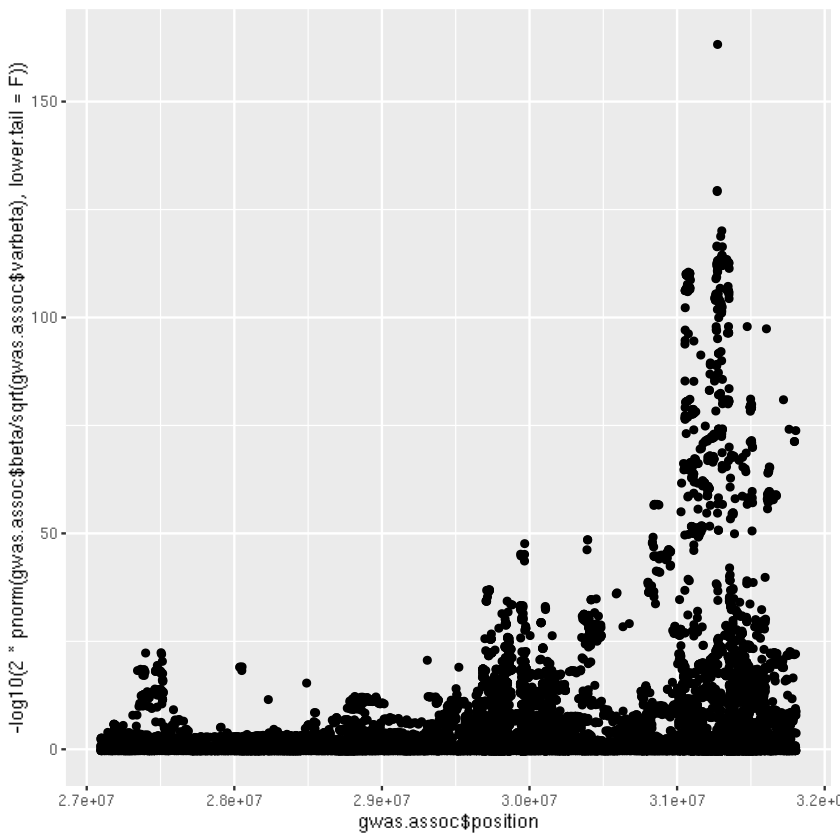

In [48]:
qplot(gwas.assoc$position, -log10(2 * pnorm(gwas.assoc$beta / sqrt(gwas.assoc$varbeta), lower.tail=F)))

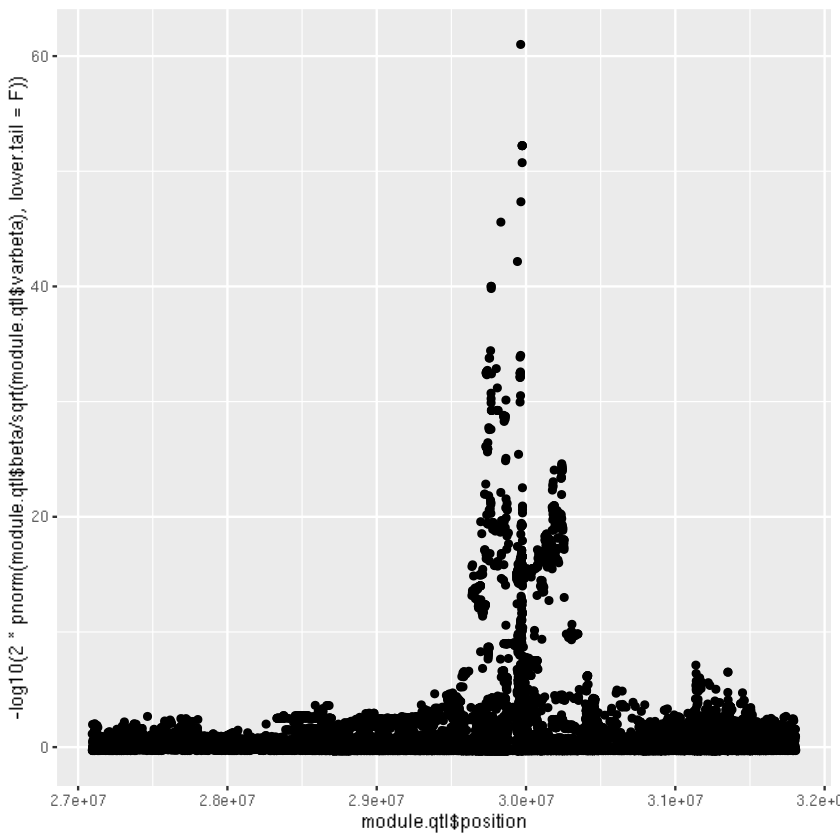

In [49]:
qplot(module.qtl$position, -log10(2 * pnorm(module.qtl$beta / sqrt(module.qtl$varbeta), lower.tail=F)))

## Platelet Counts

**Study**: [GCST90002402](https://www.ebi.ac.uk/gwas/studies/GCST90002402)

In [158]:
plt.ct <- fread("~/gains_team282/nikhil/data/EBI_GWAS_Catalog/GCST90002402_buildGRCh37.tsv", sep="\t")

In [159]:
head(plt.ct)

VARIANT,variant_id,chromosome,CHR_num,base_pair_location,GENPOS,other_allele,effect_allele,beta,p_value,MLOG10P,standard_error,effect_allele_frequency,ALT_MINOR,MA_FREQ,R2,GWSIG,INFO
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<lgl>,<dbl>
1:10177_A_AC,rs367896724,1,1,10177,0,A,AC,0.001801990,5.6E-01,0.24822207,0.00312872,0.3981220,TRUE,0.39812200,1.556178e-06,FALSE,0.467935
1:10352_T_TA,rs201106462,1,1,10352,0,T,TA,0.001944690,5.5E-01,0.26275378,0.00322148,0.3927380,TRUE,0.39273800,1.803889e-06,FALSE,0.447895
1:10511_G_A,rs534229142,1,1,10511,0,G,A,0.043531400,3.3E-01,0.48520050,0.04442930,0.0012680,TRUE,0.00126800,4.799583e-06,FALSE,0.438272
1:10616_CCGCCGTTGCAAAGGCGCGCCG_C,,1,1,10616,0,CCGCCGTTGCAAAGGCGCGCCG,C,-0.014292800,4.8E-01,0.31686298,0.02033320,0.9941574,FALSE,0.00584257,2.373142e-06,FALSE,0.468098
1:10642_G_A,rs558604819,1,1,10642,0,G,A,-0.141755000,2.0E-01,0.70630887,0.10978900,0.0002230,TRUE,0.00022300,8.960140e-06,FALSE,0.618501
1:11008_C_G,rs575272151,1,1,11008,0,C,G,0.000182102,9.7E-01,0.01193683,0.00535823,0.0860790,TRUE,0.08607900,5.217534e-09,FALSE,0.495023


In [169]:
module.qtl.sum %>%
    dplyr::filter(snp == "rs106287")

snp,beta,se,t,p,module.qtl,module,pc,qtl.locus,qtl.locus.chr,qtl.locus.start,qtl.locus.end,chr,cM,pos,minor_allele,major_allele
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>
rs106287,-2.516472e-03,0.002691337,-0.9350269,3.499053e-01,ME_92_5-6:29991224-32464002,ME_92,5,6:29991224-32464002,6,29991224,32464002,6,0,31967973,A,G
rs106287,3.389683e-02,0.003077713,11.0136432,5.072526e-26,ME_84_3-6:28836283-33995104,ME_84,3,6:28836283-33995104,6,28836283,33995104,6,0,31967973,A,G
rs106287,4.666317e-05,0.001605604,0.0290627,9.768152e-01,ME_92_1-6:29991224-32464002,ME_92,1,6:29991224-32464002,6,29991224,32464002,6,0,31967973,A,G
rs106287,1.209194e-02,0.002343613,5.1595308,3.197803e-07,ME_84_1-6:28836283-33995104,ME_84,1,6:28836283-33995104,6,28836283,33995104,6,0,31967973,A,G
rs106287,2.488959e-03,0.001244601,1.9998041,4.618842e-02,ME_92_2-6:29991224-32464002,ME_92,2,6:29991224-32464002,6,29991224,32464002,6,0,31967973,A,G
rs106287,3.547192e-04,0.003427434,0.1034941,9.175971e-01,ME_92_4-6:29991224-32464002,ME_92,4,6:29991224-32464002,6,29991224,32464002,6,0,31967973,A,G
rs106287,-6.652082e-03,0.002863215,-2.3232916,2.040093e-02,ME_84_5-6:28836283-33995104,ME_84,5,6:28836283-33995104,6,28836283,33995104,6,0,31967973,A,G
rs106287,1.609091e-03,0.003568465,0.4509196,6.520813e-01,ME_92_3-6:29991224-32464002,ME_92,3,6:29991224-32464002,6,29991224,32464002,6,0,31967973,A,G
rs106287,2.589607e-02,0.003181102,8.1405963,2.426887e-15,ME_84_4-6:28836283-33995104,ME_84,4,6:28836283-33995104,6,28836283,33995104,6,0,31967973,A,G


In [170]:
mqtl.locus.info <- module.qtl.sum %>%
    dplyr::filter(module.qtl == "ME_84_3-6:28836283-33995104") %>%
    dplyr::select(m.snp = snp, m.beta=beta, m.se=se, m.pos=pos, major_allele, minor_allele)

In [171]:
all.info <- plt.ct %>%
    dplyr::filter(variant_id %in% mqtl.locus.info$m.snp) %>%
    merge(
        ., mqtl.locus.info, 
        by.x=c("variant_id", "other_allele", "effect_allele"),
        by.y=c("m.snp", "major_allele", "minor_allele")
    ) %>%
    dplyr::select(snp=variant_id, m.beta, m.se, pos=m.pos, g.beta=beta, g.se=standard_error, g.maf=MA_FREQ)

In [172]:
module.qtl <- list()
module.qtl$beta <- all.info$m.beta
module.qtl$varbeta <- all.info$m.se^2
module.qtl$snp <- all.info$snp
module.qtl$position <- all.info$pos
module.qtl$type <- "quant"
module.qtl$sdY <- sd(eigengenes[, "ME_84_3"], na.rm=TRUE)

In [173]:
N = 408112 

In [174]:
gwas.assoc <- list()
gwas.assoc$beta <- all.info$g.beta
gwas.assoc$varbeta <- all.info$g.se^2
gwas.assoc$snp <- all.info$snp
gwas.assoc$position <- all.info$pos
gwas.assoc$type <- "quant"
gwas.assoc$N <- N
gwas.assoc$MAF <- all.info$g.maf

In [175]:
abf.res = coloc.abf(gwas.assoc, module.qtl)

Warning message in sdY.est(d$varbeta, d$MAF, d$N):
“estimating sdY from maf and varbeta, please directly supply sdY if known”
Warning message in adjust_prior(p1, nrow(df1), "1"):
“p1 * nsnps >= 1, setting p1=1/(nsnps + 1)”
Warning message in adjust_prior(p2, nrow(df2), "2"):
“p2 * nsnps >= 1, setting p2=1/(nsnps + 1)”


PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 0.00e+00  3.85e-92  0.00e+00  1.00e+00  2.19e-91 
[1] "PP abf for shared variant: 2.19e-89%"


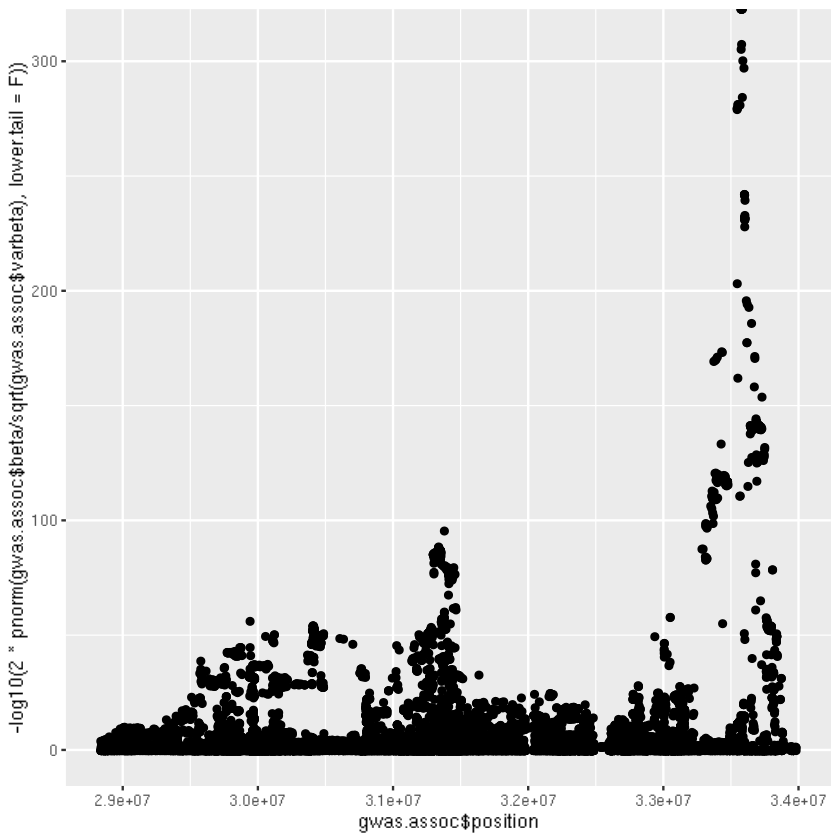

In [176]:
qplot(gwas.assoc$position, -log10(2 * pnorm(gwas.assoc$beta / sqrt(gwas.assoc$varbeta), lower.tail=F)))

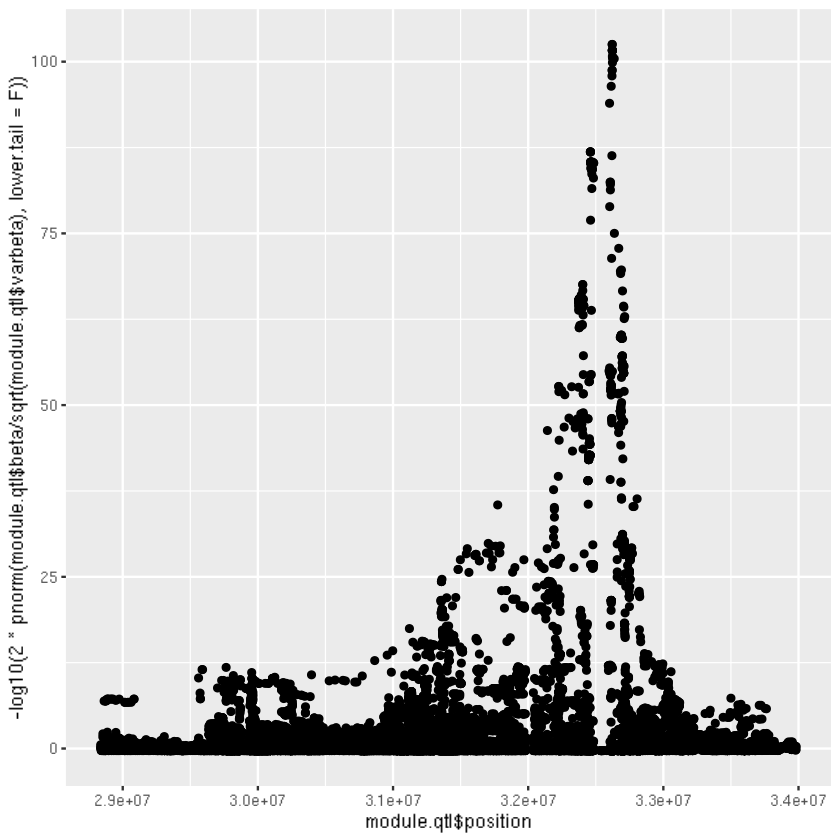

In [177]:
qplot(module.qtl$position, -log10(2 * pnorm(module.qtl$beta / sqrt(module.qtl$varbeta), lower.tail=F)))